# Symmetry and the RLCT

Following the note "Singular learning theory 5 - symmetry and RLCT" we define a realisable true distribution invariant under the action of the group $\mathbb{Z}/m\mathbb{Z} \subseteq O(2)$ for a model class consisting of feedforward ReLU networks, and then use Hamiltonian Monte Carlo to estimate the RLCT of the tuple $(p,q,\varphi)$ where $\varphi$ is a multivariate Gaussian (see below). Here the model class is of the form

$$
p(y|x,w) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{1}{2} || y - f(x,w) ||^2)
$$

where $f(x,w): \mathbb{R}^2 \rightarrow \mathbb{R}$ is a two-layer feedforward ReLU network and $q(y|x,w) = p(y|x,w_0)$ for a particular choice of weights $w_0$. We refer to $w_0$ as "the" true distribution, but it would be more accurate to say that it is some chosen point in the set of true distributions. It is important to note that currently our prior $\varphi(w)$ is a multivariate Gaussian *centered at $w_0$*. In the current setup, the model class has $m$ nodes in the hidden layer.

Our training datasets are generated from the uniform distribution $q(x_1,x_2)$ on $[-1,1] \times [-1,1]$. To match notation between the code and the Overleaf file and note "Singular learning theory 5", note that:

$m$ = `args.num_hidden_true`

$n$ = `args.num_data`

$r$ = `args.num_samples`

$d$ = `args.num_hidden`

This code is based on notebooks found here:
https://colab.research.google.com/drive/1bWQcuR5gaBPpow6ARKnPPL-dtf2EvTae#scrollTo=zNhVpzE95IGp
https://github.com/tensorflow/probability/issues/292. In that notebook the network outputs both a mean and a standard deviation, but to follow Watanabe's theory more closely we only output the mean here.

In [1]:
import os
import pickle
import math
import time
from datetime import datetime
from functools import partial
import collections

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

from sklearn.linear_model import ElasticNet

import mcmc_symmetry
from mcmc_symmetry import build_network, true_distribution, joint_log_prob_fn

np.random.seed()

TraceReturns = collections.namedtuple('TraceReturns', ['target_log_prob',
                                                       'leapfrogs_taken',
                                                       'has_divergence',
                                                       'energy',
                                                       'log_accept_ratio',
                                                        'is_accepted',
                                                          'step_size'])

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate a certain amount of memory
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=128)])
        #tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


The Markov chains are generated by `mcmc_symmetry_sample.py` and you might have to manually shutdown the Python kernel for this notebook in order to free up GPU memory. You should run something like

```
python3 mcmc_symmetry_sample.py --save-prefix="/home/murfetd/RLCT/notebooks/data" --num-betas=5 --prior-sd=10.0 --num-hidden-true=3 --num-hidden=3 --num-data=1000 --num-training-sets=3 --num-warmup=1000 --num-samples=5000 --target-accept-prob=0.9 --swish-beta=100.0 --experiment-id="27-8-2020-E" > log27-8-2020-E 2>&1 &
```

Then come back and run this notebook for pretty pictures and RLCT estimates.

In [3]:
###### SET THIS TO LOAD
experiment_id = "28-8-2020-A"
save_prefix = "/home/murfetd/RLCT/notebooks/data"
########################

args_filename = save_prefix + '/' + experiment_id + '-args.pickle'

with open(args_filename, 'rb') as handle:
  args = pickle.load(handle)
  
print(args)

def swish(X):
  return 1/args.swish_beta * tf.nn.swish( args.swish_beta * X )

if( args.nonlinearity == "relu" ):
  args.nonlinearity_func = tf.nn.relu
else:
  args.nonlinearity_func = swish

Namespace(experiment_id='28-8-2020-A', gpu_memory=128, nonlinearity=None, num_betas=5, num_data=1000, num_hidden=3, num_hidden_true=3, num_samples=100, num_temps=6, num_training_sets=3, num_warmup=10, prior_sd=10.0, save_prefix='/home/murfetd/RLCT/notebooks/data', swish_beta=100.0, target_accept_prob=0.9, use_exchange=False, x_max=1)


## 1.1 Tools for visualisation

In [4]:
def plot_distances(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    d = 0.0
    
    for (w,wprime) in zip(weights_list,center_weights):
      d += tf.square(tf.norm(w[i] - wprime))
    
    for (b,bprime) in zip(biases_list,center_biases):
      d += tf.square(tf.norm(b[i] - bprime))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  print("Mean of distances: " + str(np.mean(distances)))
  plt.plot(distances)
  
# Plot the distance between the total weight vector in a chain
# with the position in the chain X steps before
def plot_distances_offset(chain, offset):
  weights_list = chain[::2]
  biases_list = chain[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(offset,len(weights_list[0])):
    d = 0.0
    
    for w in weights_list:
      d += tf.square(tf.norm(w[i] - w[i-offset]))
    
    for b in biases_list:
      d += tf.square(tf.norm(b[i] - b[i-offset]))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  print("Mean of offset distances: " + str(np.mean(distances)))
  plt.plot(distances)

# Plot angles of each of the weight and bias vectors at each point in the chain
# measured against their initial value in the given chain
def plot_angles(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  # an array of 8 lists, each list being over all positions in the chain
  angles_weights = [[] for w in weights_list]
  angles_biases = [[] for b in biases_list]
  angles_conc = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    
    conc_current = tf.zeros([1])
    conc_orig = tf.zeros([1])
    
    for j in range(len(weights_list)):
      # the weight vector, minus the corresponding tensor in the MAP
      v_current = weights_list[j][i] - center_weights[j]
      v_orig = weights_list[j][0] - center_weights[j]
      
      # flatten the tensors
      v_current = tf.reshape(v_current,[-1])
      v_orig = tf.reshape(v_orig, [-1])
      
      conc_current = tf.concat([conc_current,v_current],axis=-1)
      conc_orig = tf.concat([conc_orig,v_orig],axis=-1)
      
      costheta = tf.tensordot(v_current,v_orig, axes=1)/( tf.norm(v_current) * tf.norm(v_orig))
      angles_weights[j].append(costheta)
      
    for j in range(len(biases_list)):
      # the bias vector, minus the corresponding tensor in the MAP
      v_current = biases_list[j][i] - center_biases[j]
      v_orig = biases_list[j][0] - center_biases[j]
      
      # flatten the tensors
      v_current = tf.reshape(v_current,[-1])
      v_orig = tf.reshape(v_orig, [-1])

      conc_current = tf.concat([conc_current,v_current],axis=-1)
      conc_orig = tf.concat([conc_orig,v_orig],axis=-1)
      
      costheta = tf.tensordot(v_current,v_orig,axes=1)/( tf.norm(v_current) * tf.norm(v_orig))
      angles_biases[j].append(costheta)
      
    cosconc = tf.tensordot(conc_current,conc_orig,axes=1)/( tf.norm(conc_current) * tf.norm(conc_orig))
    angles_conc.append(cosconc)
  
  #print("Mean of angles: " + str(np.mean(angles)))
  for i in range(len(angles_weights)):
    plt.plot(angles_weights[i], label='weights ' + str(i))

  for i in range(len(angles_biases)):
    plt.plot(angles_biases[i], label='biases ' + str(i))
    
  plt.plot(angles_conc, label='concat')
    
  plt.legend(loc='best')
  
def plot_network(w):
  network = build_network(w[::2],w[1::2],args.nonlinearity_func)
  
  def z_func(x,y):
    X = np.array([[x,y]])
    labels_dist = network(X.astype("float32"))
    return labels_dist.mean().numpy()

  num_ticks = 100
  Z = np.zeros((num_ticks,num_ticks))
  rn = np.arange(-args.x_max,args.x_max,2*args.x_max/num_ticks)
  for i in range(len(rn)):
    for j in range(len(rn)):
      Z[i,j] = z_func(rn[i],rn[j])
    
  im = plt.imshow(Z, cmap=plt.cm.RdBu)

  plt.xticks([])
  plt.yticks([])
  # adding the Contour lines with labels
  cset = plt.contour(Z,np.arange(-1,1.5,0.2),linewidths=1,cmap=plt.cm.Set2)
  plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
  plt.colorbar(im) # adding the colobar on the right

# 2. Define the true distribution

The model class is a parametric normal distribution, constructed from a neural network $f(x,w)$ which has two layers (one hidden layer) and either `ReLU` or `swish` nonlinearities. Recall that the swish function is defined for parameter $\beta > 0$
$$
\operatorname{Sw}_\beta(x) = x \frac{1}{1 + e^{-\beta x}}
$$
Only $\beta = 1$ is implemented in TensorFlow, but that is fine since
$$
\tfrac{1}{\beta} \operatorname{Sw}_1( \beta x ) = \operatorname{Sw}_{\beta}(x)
$$

Next we visualise the true distribution, by plotting the function $f(x,w_0)$

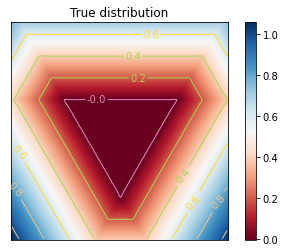

In [5]:
true_dist_state = true_distribution(args.num_hidden_true,args.num_hidden)

plt.figure()
plt.title('True distribution')
plot_network(true_dist_state)
plt.show()

In [6]:
NUM_PARAMS = 0
for s in true_dist_state:
  print("State shape", s.shape)
  NUM_PARAMS += s.shape.num_elements()
print("Total params", NUM_PARAMS)

State shape (2, 3)
State shape (3,)
State shape (3, 1)
State shape (1,)
Total params 13


# 3. Markov Chain Monte Carlo

We perform Markov Chain Monte Carlo on the weight vector for the model class $p(y|x,w)$ determined by $f(x,w)$ a feedforward ReLU network with $m$ nodes in the hidden layer, where $m$ is the symmetry factor.

### 3.1 Estimate the posterior around the true parameter

We generate, for each inverse temperature $\beta$ and dataset $D_n$, a Markov Chain via HMC starting from the true parameter $w_0$ (`center` in the code). The function `joint_log_prob_fn` computes the numerator of the posterior distribution at a given inverse temperature $\beta$. More specifically, assuming that the prior is a multivariate normal distribution centered at $w_0$ with diagonal covariance matrix $\Sigma$ with constant entries $\sigma^2$, the logarithm of this numerator is

$$
\begin{align*}
\log\big[p^\beta(D_n|w)\varphi(w)\big] &= - \beta n L_n(w) + \log\Big[ \frac{1}{\sigma \sqrt{(2\pi)^d}} \exp\big(-\frac{1}{2} \frac{ || w - w_0 ||^2 }{\sigma^2}\big) \Big] \\
&= \beta \sum_{i=1}^n \log p(y_i | x_i,w) - \frac{1}{2 \sigma^2} || w - w_0 ||^2 + C(\sigma, d)
\end{align*}
$$
where $C(\sigma,d) = - \log \sigma - \frac{d}{2} \log(2\pi)$. Note that the two contributions to the log probability are $p(y_i | x_i,w)$ and the weight regularisation $|| w - w_0 ||^2$ from the prior, and these occur with respective temperatures $1/\beta$ and $2 \sigma^2$. *A priori* the posterior will be more difficult to approximate (e.g. require more computational resources for generating Markov chains) **when $\beta$ increases** (the lower the temperature, the sharper the peaks and troughs in the density).

Note that $D_n$ is specified via `X,y` in the code, and we have the following dictionary between math and code:

$\sigma$ = `args.global_prior_bias_std`

$d$ = `NUM_PARAMS`

$w_0$ = `center`

In [7]:
n = args.num_data

betas = np.linspace(1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
                                 1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), args.num_betas)
print("Betas:")
print(betas)

Betas:
[0.10581733 0.12529108 0.14476483 0.16423858 0.18371233]


In [8]:
# We assume that the command-line part has already run and generated the chains
# This notebook is only used for analysis

mc_chains = []
mc_traces = []
      
for i in range(len(betas)):
  b = betas[i]
  
  mc_chains_b = []
  mc_traces_b = []
  mc_datasets_b = []
    
  print("Beta [" + str(i+1) + "/" + str(args.num_betas) + "] " + str(b))

  for j in range(args.num_training_sets):
    print("       Dataset [" + str(j+1) + "/" + str(args.num_training_sets) + "]")

    # Attempt to load from disk
    filename = args.save_prefix + '/' + args.experiment_id + '-beta' + str(i) + '-dataset' + str(j) + '.pickle'
    time_filename = args.save_prefix + '/' + args.experiment_id + '-beta' + str(i) + '-dataset' + str(j) + '-time.pickle'
    
    if not os.path.isfile(filename):
      print("         --WARNING-- could not find chain data")
    else:
      with open(filename, 'rb') as handle:
        fine_chain, fine_trace = pickle.load(handle)
        print("         Loaded chain from disk")
        
      with open(time_filename, 'rb') as handle:
        delta_time = pickle.load(handle)

      if( len(fine_chain[0]) < args.num_samples ):
        print("         --WARNING-- chain is short, omitting")
      else:
        mc_chains_b.append(fine_chain)
        mc_traces_b.append(fine_trace)
        
        print("         Time taken (s):", delta_time)
        print("         Acceptance rate:", fine_trace.is_accepted[-args.num_samples:].numpy().mean())
        print("         Step size:", np.asarray(fine_trace.step_size[-args.num_samples:]).mean())
        num_divergences = fine_trace.has_divergence[-args.num_samples:].numpy().sum()
        print("         Divergences: {0}/{1} = {2}".format(num_divergences,args.num_samples,num_divergences/args.num_samples))

        for c in fine_chain:
          ess_per_step = tf.reduce_min(tfp.mcmc.effective_sample_size(c[-args.num_samples:]) / args.num_samples).numpy()
          print("         ESS/step", ess_per_step)
        
  # We accept some missing datasets, but not zero data for some beta
  assert len(mc_chains_b) > 0
  
  mc_chains.append(mc_chains_b)
  mc_traces.append(mc_traces_b)

Beta [1/5] 0.10581732720669002
       Dataset [1/3]
         Loaded chain from disk
         Time taken (s): 410.81239581108093
         Acceptance rate: 1.0
         Step size: 0.014757202
         Divergences: 4/100 = 0.04
         ESS/step 0.05078571
         ESS/step 0.11371998
         ESS/step 0.126968
         ESS/step 0.23771523
       Dataset [2/3]
         Loaded chain from disk
         Time taken (s): 424.91898107528687
         Acceptance rate: 1.0
         Step size: 0.0117865205
         Divergences: 2/100 = 0.02
         ESS/step 0.084966995
         ESS/step 0.064268045
         ESS/step 0.14406213
         ESS/step 0.45167857
       Dataset [3/3]
         Loaded chain from disk
         Time taken (s): 408.94701385498047
         Acceptance rate: 1.0
         Step size: 0.012625448
         Divergences: 6/100 = 0.06
         ESS/step 0.088701144
         ESS/step 0.0767695
         ESS/step 0.14769146
         ESS/step 0.08926875
Beta [2/5] 0.125291077253887
       Da

### 3.2 Analyse the results

HMC has various hyperparameters: the number of burnin steps, the amount of time to adapt the step size, the number of leapfrog steps, and the amount of thinning we do on the resulting chain to try and generate uncorrelated samples. The "health" of the chains we are generating has to be carefully monitored:

"Tuning HMC will usually require preliminary runs with trial values... trace plots of quantities that are thought to be indicative of overall convergence should be examined... the value of the potential energy function U(q) is also usually of central importance. The autocorrelation for such quantities indicates how well the Markov chain is exploring the state space. Ideally, we would like the state after one HMC iteration to be nearly independent of the previous state." -- R. M. Neal "MCMC using Hamiltonian mechanics", Section 5.4.2

In our case the potential energy is (see Section B Nagata-Watanabe "Exchange Monte Carlo sampling from Bayesian posterior for singular learning machines") the negative log probability $-\log p^\beta(w|D_n)$. We also monitor the angle between $v_{i} - w_0$ and $v_0 - w_0$ where $v_0$ is the first weight in the chain and $w_0$ is the weight vector of the true distribution.

These graphs are all for the first dataset.

[1/5] Graphs for inverse temperature 0.10581732720669002


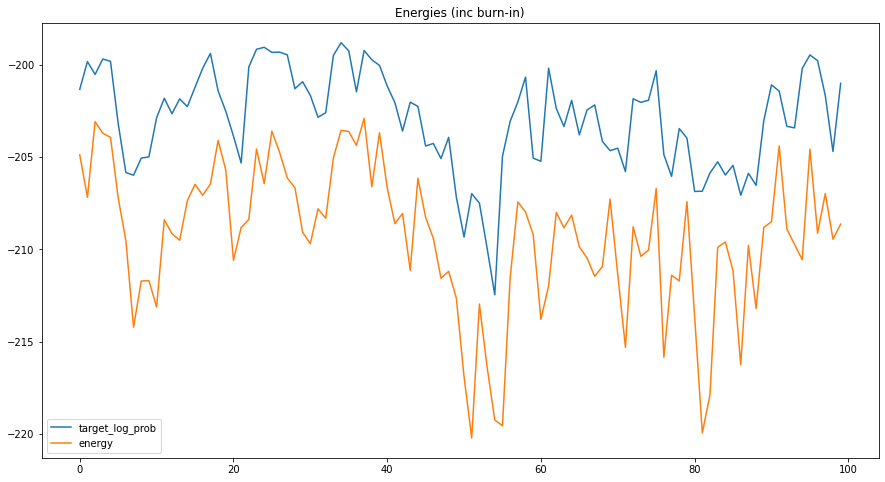

[2/5] Graphs for inverse temperature 0.125291077253887


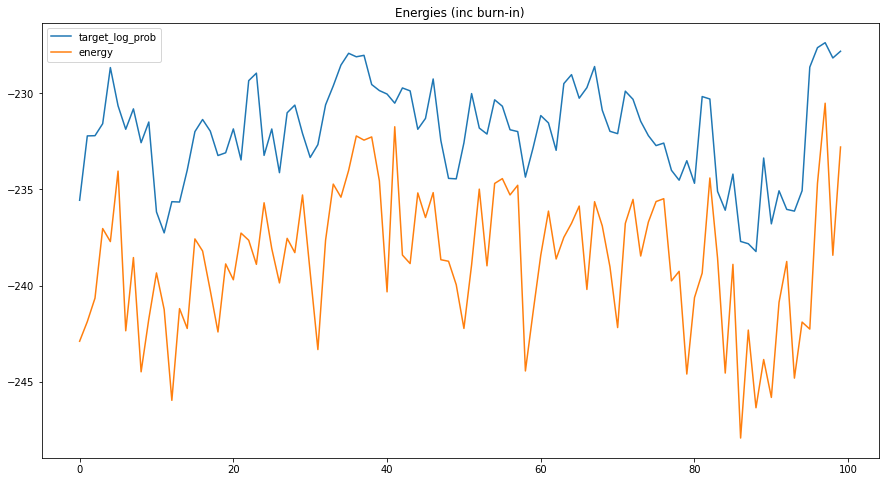

[3/5] Graphs for inverse temperature 0.14476482730108395


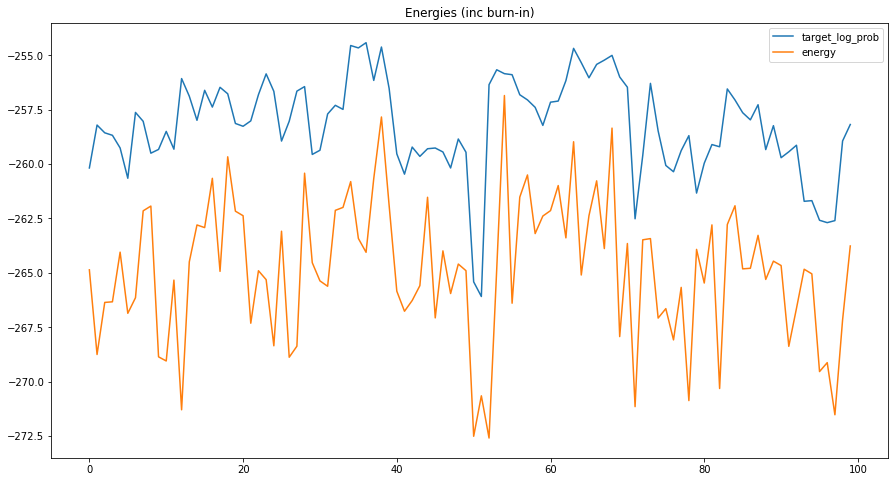

[4/5] Graphs for inverse temperature 0.1642385773482809


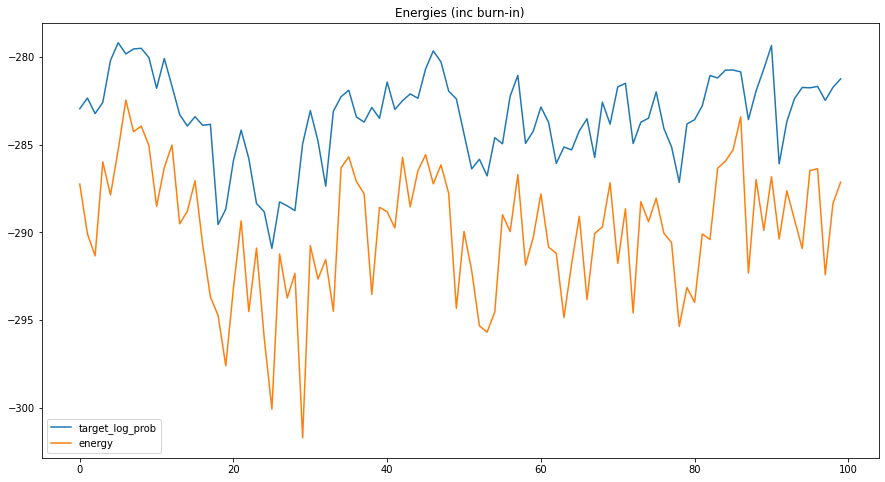

[5/5] Graphs for inverse temperature 0.18371232739547788


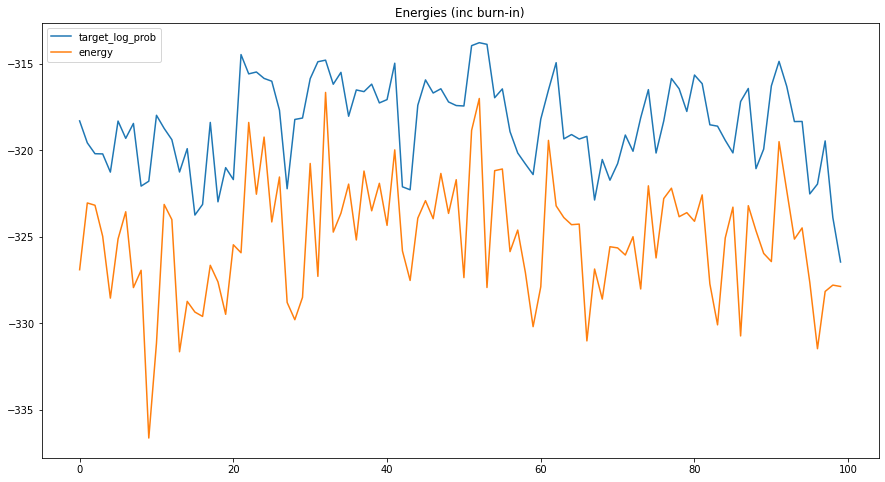

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# Hamiltonian = kinetic (random standard normal per iteration) plus potential energy (negative log posterior)
i = 0
for (b,ft) in zip(betas,mc_traces):
  thin_factor = 1
  i += 1
  print("[" + str(i) + "/" + str(args.num_betas) + "] Graphs for inverse temperature " + str(b))

  plt.figure()
  plt.title("Energies (inc burn-in)")
  plt.plot(ft[0].target_log_prob[::thin_factor], label='target_log_prob')
  plt.plot(ft[0].energy[::thin_factor], label='energy')
  plt.legend(loc='best')
  plt.show()

Note that in a high-dimensional multivariate Gaussian, the expected value of the norm of a sample is `sigma \sqrt{d}` where `sigma` is the standard deviation and `d` is the dimension. So our first sanity check is to see whether the mean of norms of the samples in our Markov Chain line up with the expected norm that we would expect from sampling from the new localised prior.

Mean sample norm from global prior Gaussian: 36.05551275463989

[1/5] Graphs for inverse temperature 0.10581732720669002
Mean of distances: 32.61716


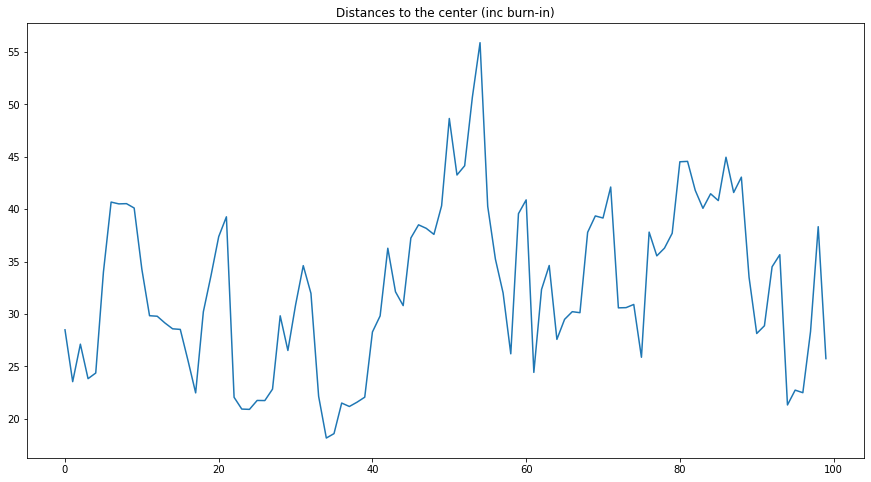

[2/5] Graphs for inverse temperature 0.125291077253887
Mean of distances: 33.008404


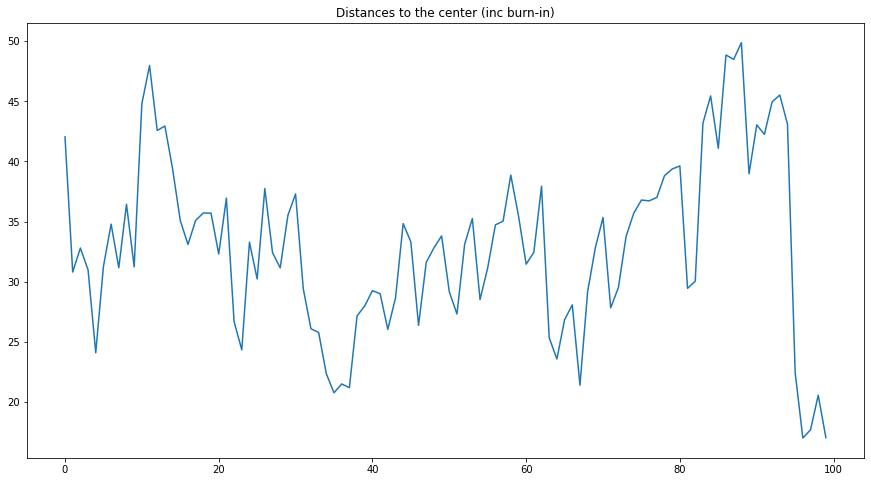

[3/5] Graphs for inverse temperature 0.14476482730108395
Mean of distances: 33.113087


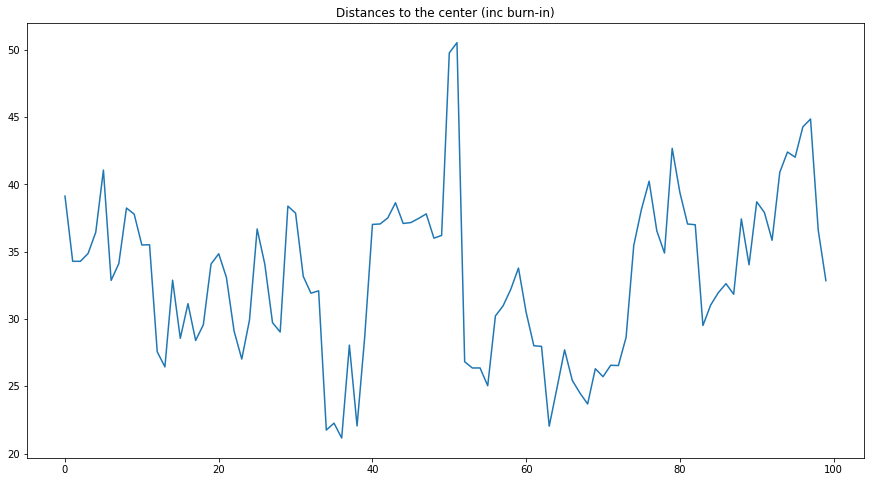

[4/5] Graphs for inverse temperature 0.1642385773482809
Mean of distances: 35.31413


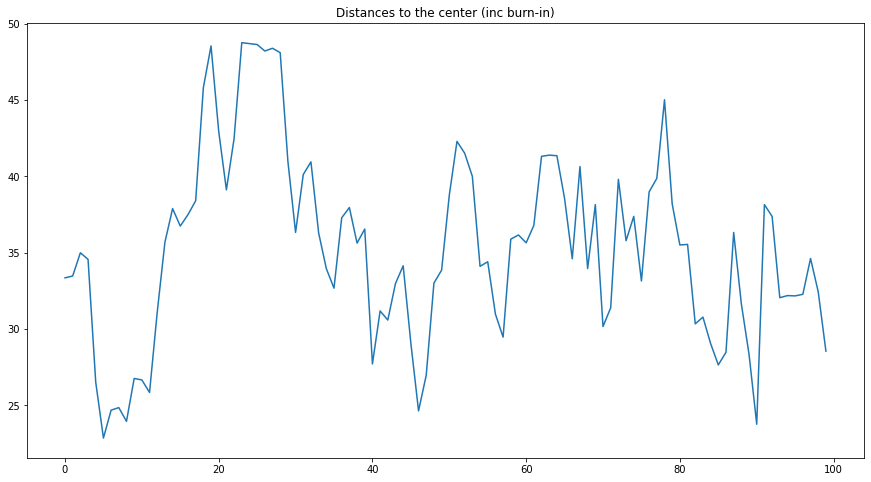

[5/5] Graphs for inverse temperature 0.18371232739547788
Mean of distances: 33.061817


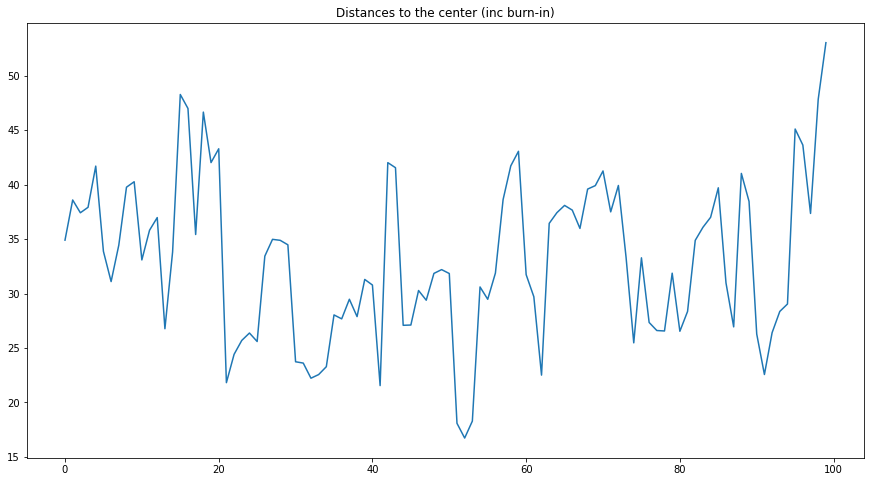

In [10]:
print("Mean sample norm from global prior Gaussian: " + str(args.prior_sd * np.sqrt(NUM_PARAMS)))

i = 0

print("")

for (b,fc) in zip(betas,mc_chains):
  i += 1
  thin_factor = 1
  print("[" + str(i) + "/" + str(args.num_betas) + "] Graphs for inverse temperature " + str(b))

  short_chain = []

  for c in fc[0]:
    short_chain.append(c[::thin_factor])
    
  plt.figure()
  plt.title("Distances to the center (inc burn-in)")
  plot_distances(short_chain, true_dist_state)
  plt.show()

We let `short_chain` be a small segment from the overall chain, and plot the angles that various components of the weight and bias vector make with their values at the beginning of `short_chain`. The cosines of angles between the full vectors are graphed as `concat`. We can see that initially the cosine of the angle is `1`, as expected, and then decreases to `0`. Note that in high dimensions two generic vectors are orthogonal, so this is expected.

These graphs, together with the above discussion of distances, support the hypothesis that the posterior around `center` with the localised prior, is spherical at the expected distance and not concentrated in just a small neighborhood of a point on that sphere.

--------------------------------
Inverse temperature beta 0.10581732720669002


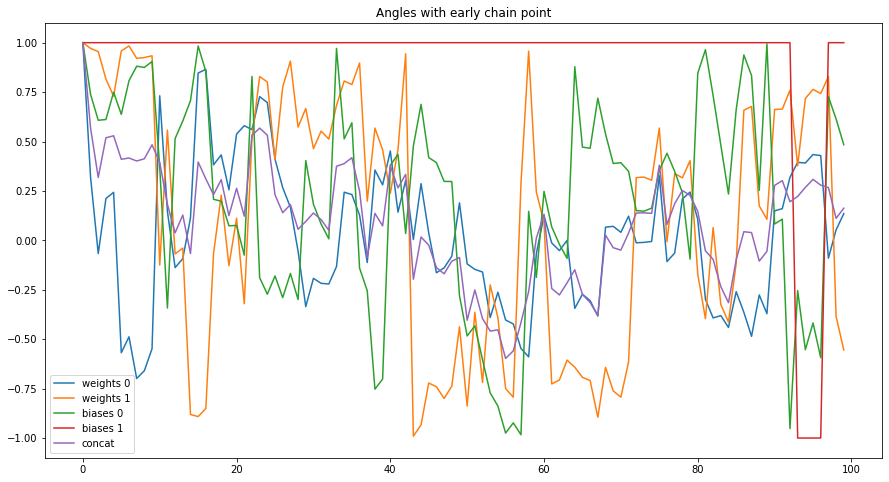

--------------------------------
Inverse temperature beta 0.125291077253887


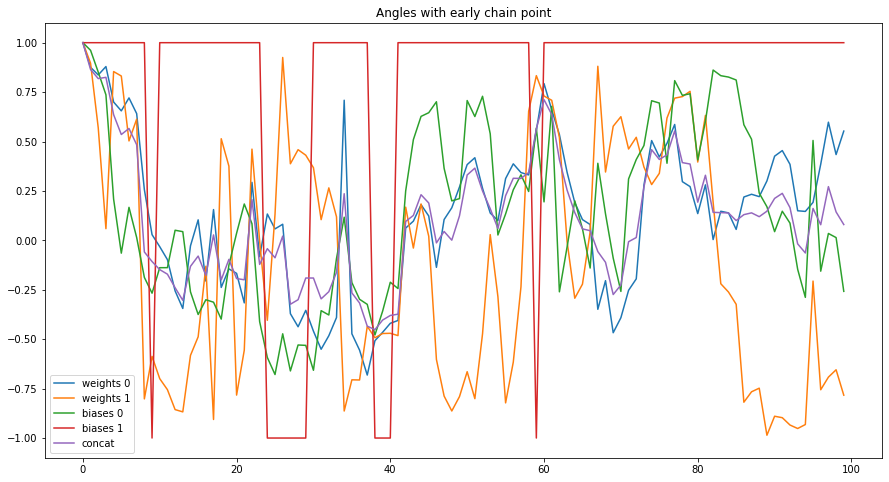

--------------------------------
Inverse temperature beta 0.14476482730108395


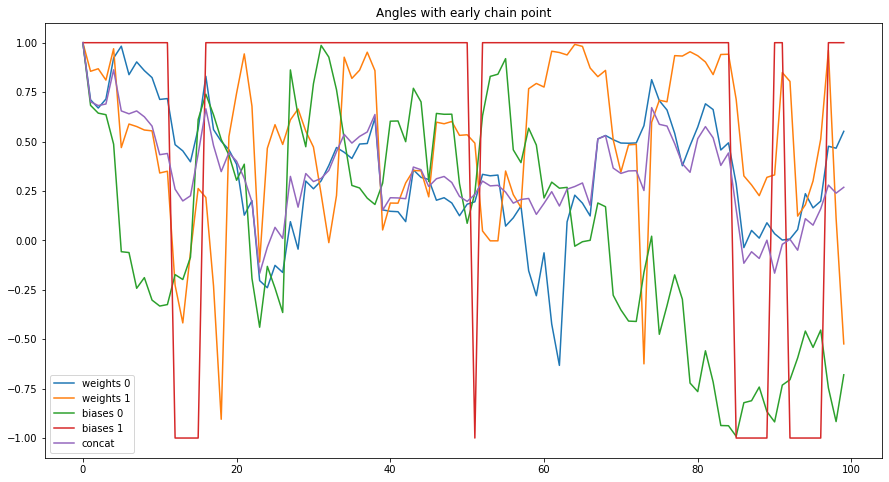

--------------------------------
Inverse temperature beta 0.1642385773482809


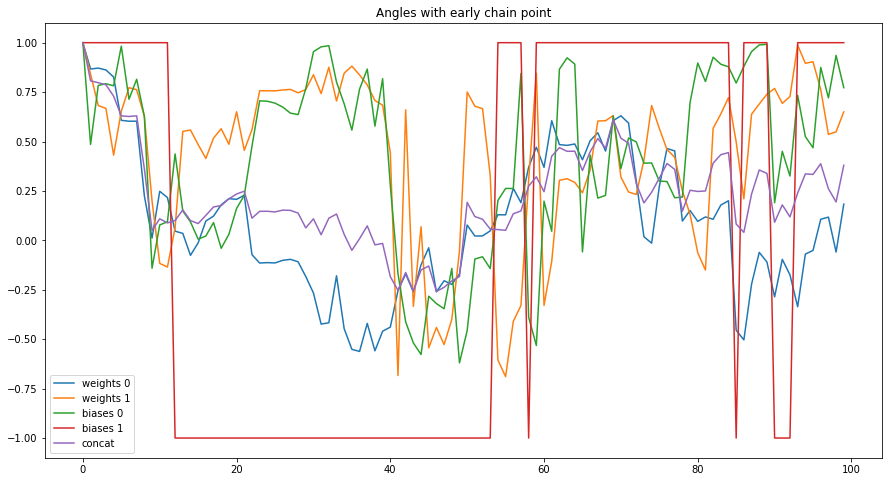

--------------------------------
Inverse temperature beta 0.18371232739547788


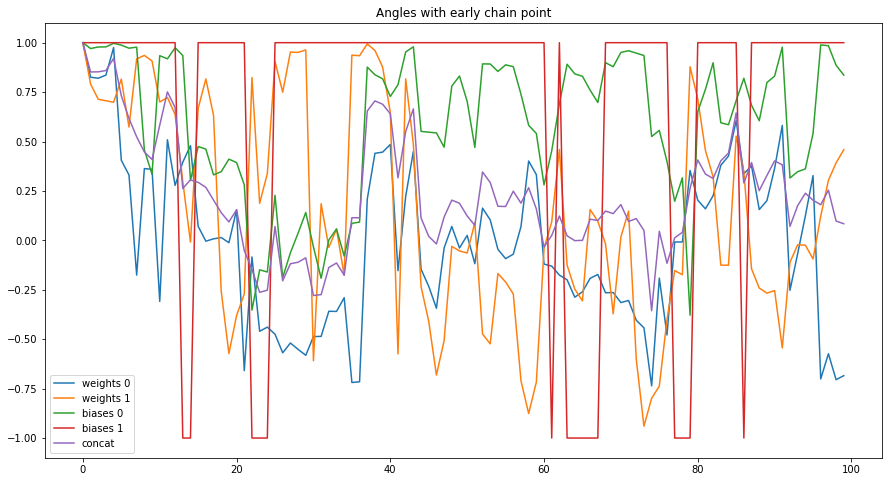

In [11]:
# Note that the dot product of high dimensional vectors is generically zero, as the orthogonal subspace
# is dim(V)-1. We graph the cos(angle) between the first point in the short_chain and the following chain steps,
# between the various weight and bias vectors, and the full weight/bias vector (concat)

short_chain_length = 1000
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

# These visualiations are all for the first dataset
for (b,fc) in zip(betas,mc_chains):
  print("--------------------------------")
  print("Inverse temperature beta " + str(b))
  
  short_chain = []

  for c in fc[0]:
    short_chain.append(c)
  
  plt.figure()
  plt.title("Angles with early chain point")
  plot_angles(short_chain, true_dist_state)
  plt.show()

--------------------------------
Inverse temperature beta 0.18371232739547788


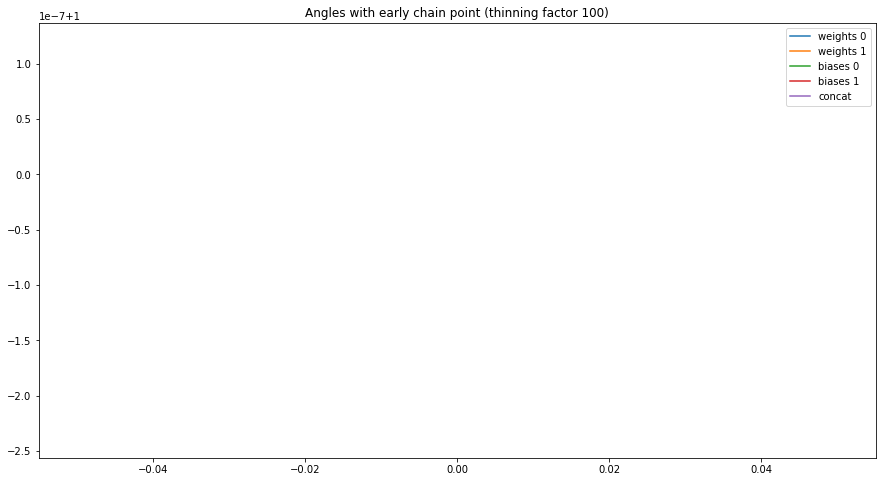

In [12]:
thin_factor = 100

b = betas[-1]
fc = mc_chains[-1]

print("--------------------------------")
print("Inverse temperature beta " + str(b))

short_chain = []

for c in fc[0]:
  short_chain.append(c[-args.num_samples::thin_factor])

plt.figure()
plt.title("Angles with early chain point (thinning factor " + str(int(thin_factor)) + ")")
plot_angles(short_chain, true_dist_state)
plt.show()

### 3.3 Estimating the RLCT

The RLCT estimates are based on our estimates of the expected value of $nL_n(w)$. If $f(x,w)$ denotes the ReLU network with weights $w$, then
$$
p(y|x,w) = \frac{1}{(2 \pi)^{1/2}} \exp\big(-\tfrac{1}{2}|| y - f(x,w) ||^2\big)
$$
then we calculate
$$
\begin{align*}
nL_n(w) &= -\sum_{i=1}^n \log p(y_i|x_i,w)\\
        &= -\sum_{i=1}^n \log\Big[ \frac{1}{(2 \pi)^{1/2}} \exp\big(-\tfrac{1}{2}|| y_i - f(x_i,w) ||^2\big) \Big]\\
        &= -\sum_{i=1}^n\big[ -(1/2)\log(2\pi) - \tfrac{1}{2}|| y_i - f(x_i,w) ||^2 \big]\\
        &= \tfrac{n}{2} \log(2\pi) + \tfrac{1}{2} \sum_{i=1}^n || y_i - f(x_i,w) ||^2 
\end{align*}
$$
In particular at the true parameter $w_0$ (what we call `center` in the code) we have
$$
nL_n(w_0) = \tfrac{n}{2} \log(2 \pi)
$$

Beta [1/5] 0.10581732720669002
    E_w[nL_n(w)] over datasets: [1465.9047, 1525.061, 1466.5553]
    E_{D_n}E_w[nL_n(w)]: 1485.8403
    Std_{D_n}E_w[nL_n(w)]: 27.734497

Beta [2/5] 0.125291077253887
    E_w[nL_n(w)] over datasets: [1477.1167, 1427.3618, 1443.7072]
    E_{D_n}E_w[nL_n(w)]: 1449.3951
    Std_{D_n}E_w[nL_n(w)]: 20.706724

Beta [3/5] 0.14476482730108395
    E_w[nL_n(w)] over datasets: [1455.1882, 1442.3235, 1439.3596]
    E_{D_n}E_w[nL_n(w)]: 1445.6237
    Std_{D_n}E_w[nL_n(w)]: 6.870478

Beta [4/5] 0.1642385773482809
    E_w[nL_n(w)] over datasets: [1431.4159, 1441.9434, 1474.3916]
    E_{D_n}E_w[nL_n(w)]: 1449.2504
    Std_{D_n}E_w[nL_n(w)]: 18.289728

Beta [5/5] 0.18371232739547788
    E_w[nL_n(w)] over datasets: [1473.8081, 1458.739, 1419.7374]
    E_{D_n}E_w[nL_n(w)]: 1450.7616
    Std_{D_n}E_w[nL_n(w)]: 22.783619


n              = 1000
r              = 100
D/2            = 6.5
nL_n(w_0)      = 918.9385332046727

OLS estimate of RLCT    = 8.11177951673668
Robust estim

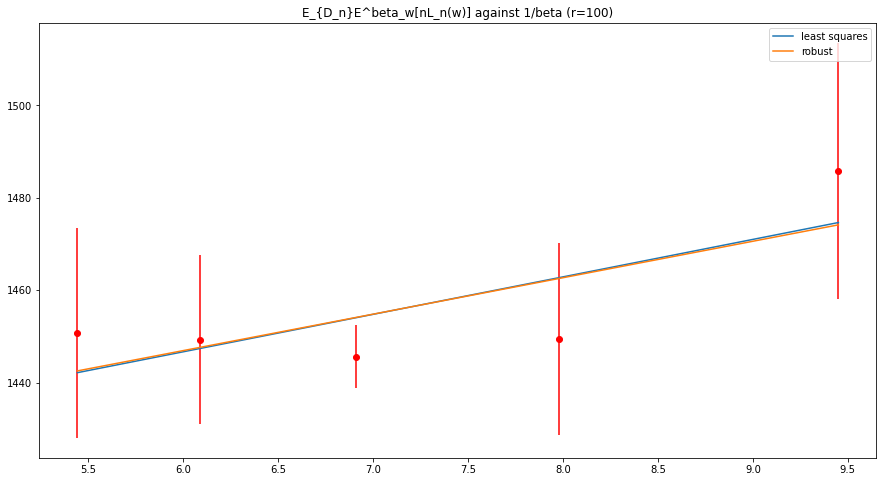

In [13]:
# Recall that the log likelihood of a weight vector, with respect to the training data and the original global prior used for training, is `joint_log_prob`. 
estimates = []
estimates_err = []

for i in range(args.num_betas):
  print("Beta [" + str(i+1) + "/" + str(args.num_betas) + "] " + str(betas[i]))

  EnLn_estimates = []

  for j in range(args.num_training_sets):
    # Attempt to load from disk
    EnLn_filename = args.save_prefix + '/' + args.experiment_id + '-beta' + str(i) + '-dataset' + str(j) + '-estimate.pickle'

    if not os.path.isfile(EnLn_filename):
      print("    --WARNING-- could not find EnLn file")
    else:
      with open(EnLn_filename, 'rb') as handle:
        mean_Ln_sample = pickle.load(handle)
        EnLn_estimates.append(mean_Ln_sample)
  
  assert len(EnLn_estimates) > 0
  
  print("    E_w[nL_n(w)] over datasets: " + str(EnLn_estimates))
  print("    E_{D_n}E_w[nL_n(w)]: " + str(np.mean(EnLn_estimates)))
  print("    Std_{D_n}E_w[nL_n(w)]: " + str(np.std(EnLn_estimates)))
  print("")
  
  estimates.append(np.mean(EnLn_estimates))
  estimates_err.append(np.std(EnLn_estimates))

print("")

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

plt.figure()
r = int(args.num_samples)
plt.title("E_{D_n}E^beta_w[nL_n(w)] against 1/beta (r=" + str(r) + ")")
plt.errorbar(x=1/betas, y=estimates, yerr=estimates_err,fmt='ro')

m, b = np.polyfit([1/b for b in betas], estimates, 1)
print("n              = " + str(args.num_data))
print("r              = " + str(r))
print("D/2            = " + str(NUM_PARAMS/2))
print("nL_n(w_0)      = " + str(args.num_data/2 * np.log(2 * np.pi)))

plt.plot(1/betas, [m*x + b for x in 1/betas], label='least squares')

# robust ls fit
regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
regr.fit((1 / betas).reshape(args.num_betas, 1), estimates)
b_robust = regr.intercept_
m_robust = regr.coef_[0]

print("\nOLS estimate of RLCT    = " + str(m))
print("Robust estimate of RLCT = " + str(m_robust))

plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='robust')

plt.legend(loc='best')

plt.show()


OLS estimate of RLCT    = 8.11177951673668
Robust estimate of RLCT = -0.6453371906292856


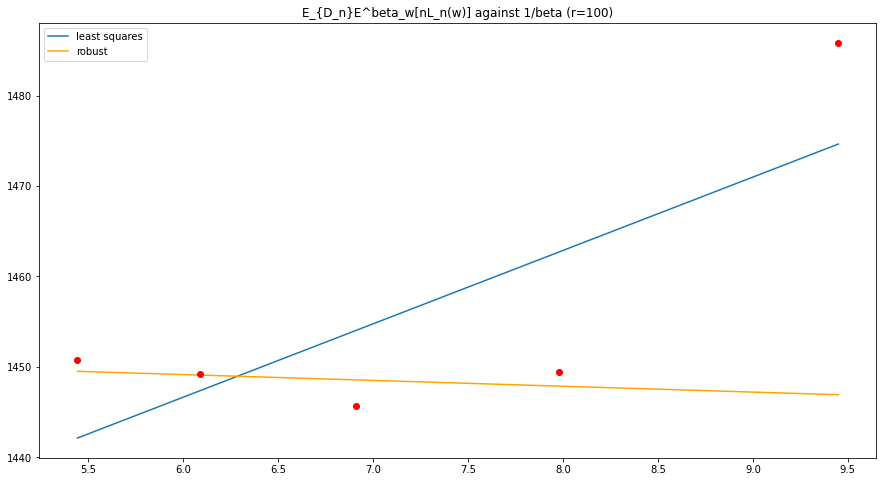

In [16]:
#### Same as above, but with a closer crop of the datapoints

plt.figure()
plt.title("E_{D_n}E^beta_w[nL_n(w)] against 1/beta (r=" + str(r) + ")")
plt.errorbar(x=1/betas, y=estimates, fmt='ro')

m, b = np.polyfit([1/b for b in betas], estimates, 1)

plt.plot(1/betas, [m*x + b for x in 1/betas], label='least squares')

# robust ls fit
sub_betas = betas
sub_estimates = estimates

regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
regr.fit((1 / sub_betas).reshape(len(sub_betas), 1), sub_estimates)
b_robust = regr.intercept_
m_robust = regr.coef_[0]
print("\nOLS estimate of RLCT    = " + str(m))
print("Robust estimate of RLCT = " + str(m_robust))

plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='robust', color='orange')

plt.legend(loc='best')

plt.show()


Second robust estimate of RLCT = 22.622500170124987


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

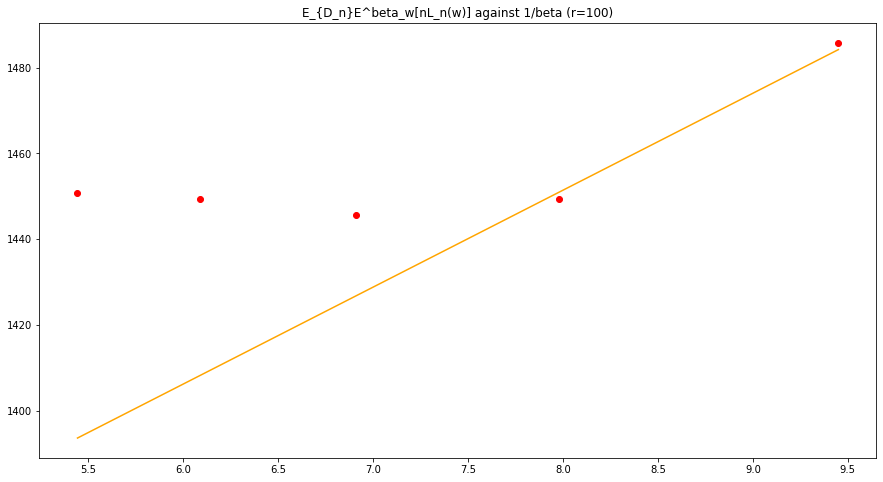

In [15]:
#### Modified for multiple components

if( len(mc_chains) > 1 ):
  plt.figure()
  plt.title("E_{D_n}E^beta_w[nL_n(w)] against 1/beta (r=" + str(r) + ")")
  plt.errorbar(x=1/betas, y=estimates, fmt='ro')
  
  # robust ls fit
  sub_betas = betas[:-3]
  sub_estimates = estimates[:-3]
  
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
  regr.fit((1 / sub_betas).reshape(len(sub_betas), 1), sub_estimates)
  b_robust = regr.intercept_
  m_robust = regr.coef_[0]
  print("\nSecond robust estimate of RLCT = " + str(m_robust))
  
  plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='second', color='orange')
  
  # robust ls fit
  sub_betas = betas[6:]
  sub_estimates = estimates[6:]
  
  regr = ElasticNet(random_state=0, fit_intercept=True, alpha=0.1)
  regr.fit((1 / sub_betas).reshape(len(sub_betas), 1), sub_estimates)
  b_robust = regr.intercept_
  m_robust = regr.coef_[0]
  print("\nFirst robust estimate of RLCT = " + str(m_robust))
  
  plt.plot(1/betas, [m_robust * x + b_robust for x in 1/betas], label='first', color='blue')

  plt.legend(loc='best')
  
  plt.show()